In [3]:
import albumentations as albu
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from image_segmentation.common import PROJECT_ROOT, DATA_LOADER_SEED
from image_segmentation.data.utils import Augment, load_test_images, load_train_valid_images
from image_segmentation.data.datamodule import DataModule
from image_segmentation.models.models import get_compiled_model
import tensorflow as tf
from imutils import paths
from typing import Tuple, Sequence
import random

import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf

import cv2
import matplotlib.pyplot as plt

%load_ext autoreload

%autoreload 2

from image_segmentation.models.tf_unet.unet import unet_constructor

In [4]:
img_path = os.path.join(PROJECT_ROOT, 'data/membrane', 'train/image/0.png')
mask_path = os.path.join(PROJECT_ROOT, 'data/membrane', 'train/label/0.png')
data_path = [img_path, mask_path]


In [5]:
img, mask = load_train_valid_images(data_path=data_path)

In [6]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 2, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [7]:
print(img.shape, mask.shape)

(512, 512, 1) (512, 512, 1)


In [8]:
original_height, original_width = img.shape[:2]

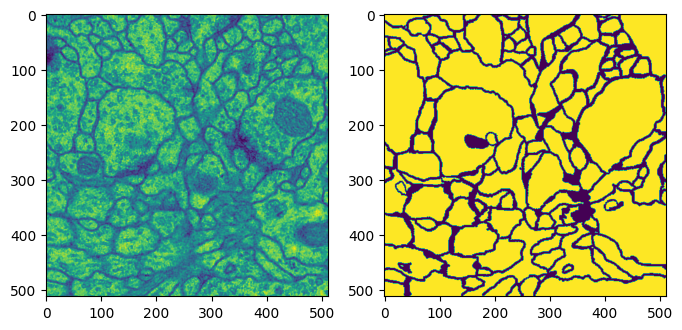

In [9]:
visualize(img, mask)

In [10]:
initialize(version_base=None, config_path="../conf", job_name="test_app")

hydra.initialize()

In [18]:
cfg = compose(config_name="default.yaml")

In [12]:
datamodule = hydra.utils.instantiate(cfg.nn.data, _recursive_=False)
datamodule.prepare_data()

In [13]:
datamodule.setup()

In [14]:
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()
test_dataloader = datamodule.test_dataloader()

In [15]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

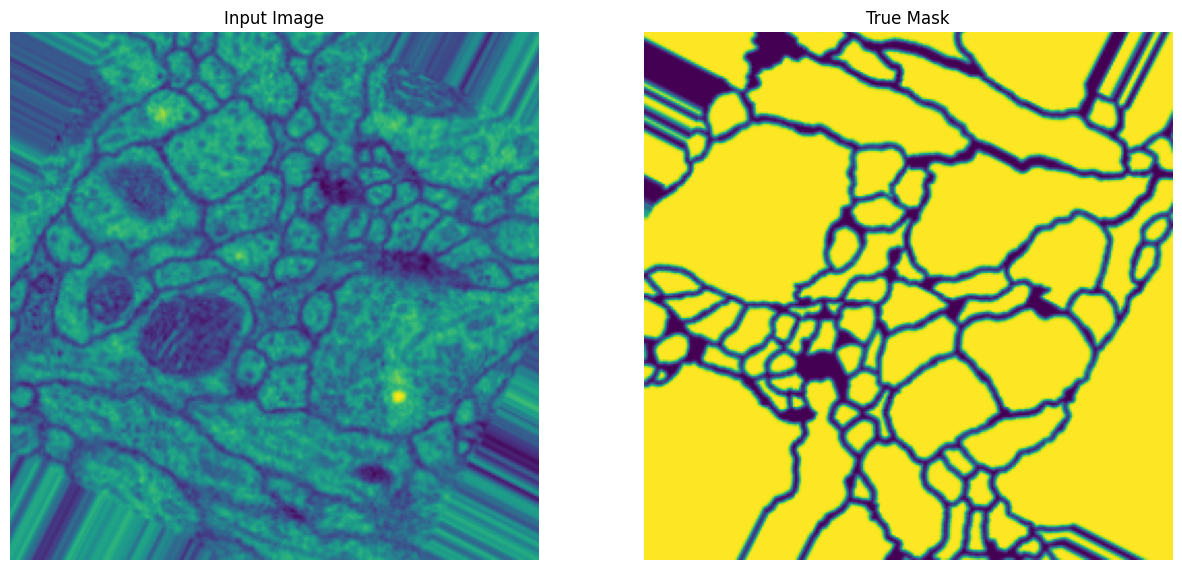

In [16]:
for images, masks in train_dataloader.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [19]:
height = cfg.nn.data.resize.height
width = cfg.nn.data.resize.width

unet_config = cfg.nn.unet.structure
blocks_config = cfg.nn.unet.blocks
unet_model, original_output_size = unet_constructor(image_size=(height, width), blocks_config=blocks_config, **unet_config)

In [20]:
original_output_size

TensorShape([None, 250, 250, 1])

In [21]:
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 resnet_block (ResnetBlock)     (None, 256, 256, 64  38208       ['inputs[0][0]']                 
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 64  0           ['resnet_block[0][0]']           
                                )                                                              

In [22]:
# unet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

unet_model = get_compiled_model(
        model=unet_model,
        optimizer_config=cfg.nn.module.optimizer,
        custom_loss_config=cfg.nn.module.custom_loss,
        metrics_config=cfg.nn.module.metrics,
    )



In [23]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], pred_mask])
  else:
    display([sample_image, sample_mask, unet_model.predict(sample_image[tf.newaxis, ...])[0]])

1/1 [==============================] - 1s 627ms/step


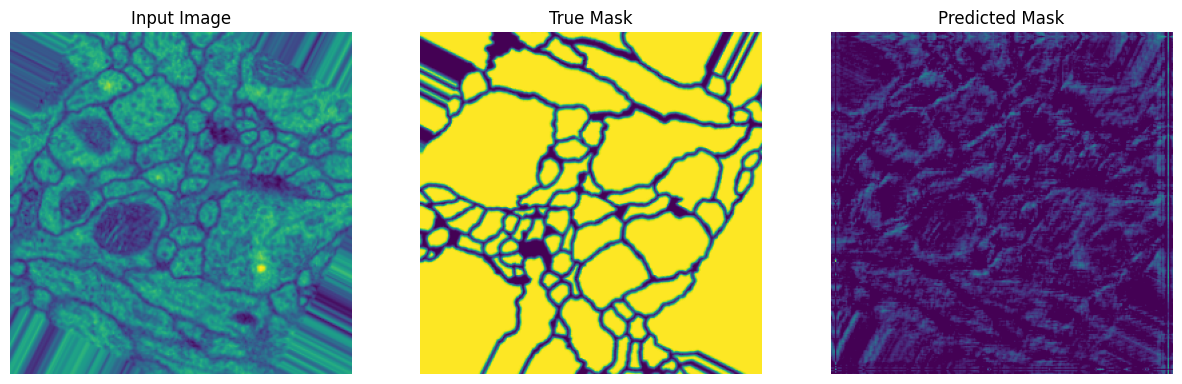

In [24]:
show_predictions()

In [25]:
img = next(iter(test_dataloader))

In [26]:
output = unet_model.predict(img)

1/1 [==============================] - 1s 503ms/step


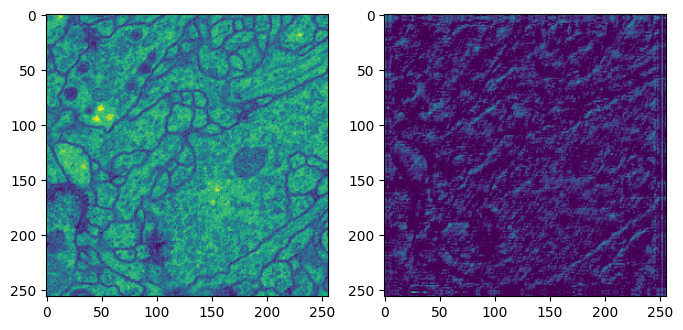

In [27]:
visualize(img[0], output[0])

In [29]:
unet_model_bis.fit(train_dataloader, epochs=5, validation_data=val_dataloader)

Epoch 1/5
48/48 [==============================] - 136s 3s/step - loss: 0.5209 - categorical_accuracy: 1.0000 - categorical_crossentropy: 9.3000e-08 - val_loss: 0.5253 - val_categorical_accuracy: 1.0000 - val_categorical_crossentropy: 9.5182e-08
Epoch 2/5
48/48 [==============================] - 136s 3s/step - loss: 0.5188 - categorical_accuracy: 1.0000 - categorical_crossentropy: 9.3000e-08 - val_loss: 0.6542 - val_categorical_accuracy: 1.0000 - val_categorical_crossentropy: 9.5182e-08
Epoch 3/5
48/48 [==============================] - 135s 3s/step - loss: 0.5161 - categorical_accuracy: 1.0000 - categorical_crossentropy: 9.3000e-08 - val_loss: 0.5632 - val_categorical_accuracy: 1.0000 - val_categorical_crossentropy: 9.5182e-08
Epoch 4/5
48/48 [==============================] - 135s 3s/step - loss: 0.5112 - categorical_accuracy: 1.0000 - categorical_crossentropy: 9.3000e-08 - val_loss: 0.6675 - val_categorical_accuracy: 1.0000 - val_categorical_crossentropy: 9.5182e-08
Epoch 5/5
48/48 

1/1 [==============================] - 0s 430ms/step


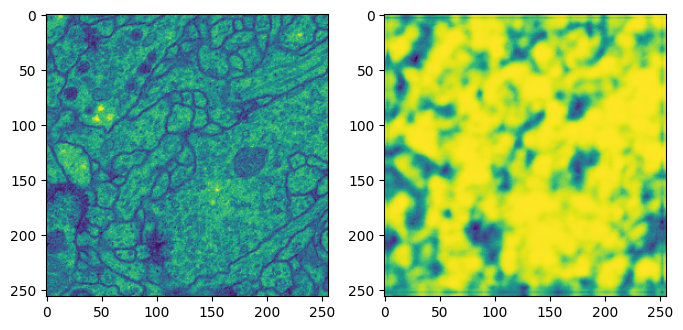

In [32]:
img = next(iter(test_dataloader))
output = unet_model.predict(img)
visualize(img[0], output[0])